**Trabajo Práctico final Procesamiento del Lenguaje Natural**

*Lucía Masciángelo*

*Fecha de entrega:* 18/12/2024

*Profesores:* Juan Pablo Manson, Alan Geary, Constantino Ferrucci, Dolores Sollberger

**Introducción al Proyecto Ejercicio 1**

Este código implementa un sistema de recuperación y generación de información (RAG) centrado en el juego de mesa "Lost Ruins of Arnak". Combina técnicas de Procesamiento de Lenguaje Natural (NLP), Machine Learning y bases de datos estructuradas y no estructuradas para clasificar consultas y responder preguntas de manera automatizada.

El flujo de trabajo principal puede dividirse en las siguientes etapas:

1) **Extracción de Datos**

  * **PDF:** Se descarga y extrae texto del reglamento del juego en formato PDF utilizando `pdfplumber`.

  * **Web Scraping:** Se realiza scraping de reseñas y opiniones sobre el juego desde un sitio web utilizando `BeautifulSoup`.

2) **Construcción de Bases de Datos**
  * **Base de Datos Textual:**
Se almacenan fragmentos de texto procesados en una base vectorial ChromaDB.
Se generan embeddings para cada fragmento utilizando el modelo E5-Large de `transformers`.
  * **Base de Datos Tabular:**
Contiene datos estructurados sobre el juego, como cantidad de jugadores, duración, puntuación y precios.
Los datos se almacenan en un DataFrame de `pandas` y se exportan a CSV.
  * **Base de Datos de Grafos:**
Se modelan las relaciones entre autores, ilustradores, mecánicas y premios del juego utilizando `NetworkX`.

3) **Clasificación de Consultas**
Se implementan dos enfoques para clasificar las consultas de entrada en tres categorías (text, table, graph):

* **Clasificador SVM:** Entrenado con embeddings generados a partir de ejemplos de entrenamiento.
* **Clasificador basado en LLM:** Utiliza el modelo `Flan-T5` con un prompt diseñado para realizar la clasificación.

4) **Flujo RAG (Retrieval-Augmented Generation)**
Una vez clasificada la consulta:

- **Recuperación:** Se busca información relevante desde:
    * La base textual (búsqueda semántica en ChromaDB).
    * La base tabular (filtrado de datos estructurados).
    * La base de grafos (consultas sobre relaciones entre nodos).
- **Generación de Respuestas:** Se utiliza el modelo `Flan-T5-small` para generar respuestas basadas en la consulta y el contexto recuperado.

5)  **Ejecución Completa**

Se proporciona un ejemplo práctico donde se ingresa una consulta, el sistema clasifica la categoría, recupera el contexto apropiado y genera una respuesta clara y precisa.

Link a la página oficial del juego (BGG): https://boardgamegeek.com/boardgame/312484/lost-ruins-of-arnak/forums/0

Link al rulebook del juego en español: https://czechgames.com/files/rules/lost-ruins-of-arnak-rules-es.pdf

Opinión de Misut Meeple: https://misutmeeple.com/2021/04/resena-las-ruinas-perdidas-de-arnak/#opinion



# Instalación de librerías

In [1]:
# Instalación de todas las librerías necesarias en una sola línea
!pip install \
    transformers \
    langchain \
    chromadb \
    pdfplumber \
    sentence-transformers \
    chromadb[duckdb] \
    langchain-community \
    langchain-openai \
    langchain-chroma \
    torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of chromadb to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of chromadb[duckdb] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.9/617.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━

# Base de datos de Texto

**Extracción de Texto desde PDF:** Este bloque descarga un PDF con las reglas del juego desde una URL y extrae el texto usando `pdfplumber`.

In [2]:
import requests
import pdfplumber
import os
from io import BytesIO

# URL del PDF
url = "https://czechgames.com/files/rules/lost-ruins-of-arnak-rules-es.pdf"

# Descargar el PDF
response = requests.get(url)
pdf_file = BytesIO(response.content)

# Abrir el PDF con pdfplumber
with pdfplumber.open(pdf_file) as pdf:
    text = ""
    for page in pdf.pages:
        text += page.extract_text()

# Guardar el texto extraído en un archivo .txt
output_file = "arnak_rules.txt"
with open(output_file, "w", encoding="utf-8") as f:
    f.write(text)

print(f"Texto extraído guardado en: {output_file}")

Texto extraído guardado en: arnak_rules.txt


**Extracción de Contenido Web (Web Scraping):** Este bloque realiza web scraping de una reseña del juego usando BeautifulSoup, extrayendo títulos y contenido asociado.

In [3]:
# Instalar las librerías necesarias
!pip install requests beautifulsoup4

import requests
from bs4 import BeautifulSoup

# URL de la página
url = "https://misutmeeple.com/2021/04/resena-las-ruinas-perdidas-de-arnak/#opinion"

# Hacer una solicitud a la página
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Extraer todos los títulos y sus contenidos
titles = soup.find_all('h2')  # Buscar todos los títulos en <h2>
output_text = ""

for title in titles:
    title_text = title.get_text(strip=True)  # Extraer el texto del título
    next_elements = title.find_next_siblings()  # Buscar elementos después del título

    # Extraer contenido debajo del título hasta el próximo <h2>
    content = ""
    for elem in next_elements:
        if elem.name == 'h2':  # Parar al encontrar otro <h2>
            break
        content += elem.get_text(strip=True) + "\n"

    # Agregar título y contenido al texto final
    output_text += f"{title_text}\n{'=' * len(title_text)}\n{content}\n\n"

# Guardar el texto en un archivo .txt
output_file = "misutmeeple_resena_completa.txt"
with open(output_file, "w", encoding="utf-8") as f:
    f.write(output_text)

print(f"Texto extraído guardado en: {output_file}")

Texto extraído guardado en: misutmeeple_resena_completa.txt


**Combinación de Archivos de Texto:** Este código combina los textos del PDF y de la página web en un solo archivo, para luego poder hacerles el embedding y guardarlo en Chromadb

In [4]:
# Nombres de los archivos existentes
file1 = "arnak_rules.txt"  # Archivo del PDF
file2 = "misutmeeple_resena_completa.txt"  # Archivo del web scraping

# Nombre del archivo combinado
output_file = "arnak_combinado.txt"

# Leer y combinar el contenido de ambos archivos
with open(file1, "r", encoding="utf-8") as f1, open(file2, "r", encoding="utf-8") as f2:
    content1 = f1.read()
    content2 = f2.read()

# Escribir el contenido combinado en un nuevo archivo
with open(output_file, "w", encoding="utf-8") as f_out:
    f_out.write("=== Texto del PDF ===\n")
    f_out.write(content1 + "\n")
    f_out.write("=== Texto del Web Scraping ===\n")
    f_out.write(content2)

print(f"Archivo combinado guardado como: {output_file}")


Archivo combinado guardado como: arnak_combinado.txt


## Creamos embeddings y guardamos en Chromadb

**Generación de Embeddings y División de Texto:** Genera embeddings con un modelo de transformers y divide el texto en fragmentos más manejables utilizando RecursiveCharacterTextSplitter.

In [5]:
from transformers import AutoTokenizer, AutoModel
import torch

# Cargar el modelo y el tokenizer
model_name = "intfloat/e5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def generate_embedding(text):
    """
    Genera embeddings para un texto dado utilizando el modelo E5.
    """
    # Agregar prefijo necesario para `e5`
    inputs = tokenizer(f"query: {text}", return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Usamos el embedding del token [CLS]
    embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return embedding

tokenizer_config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Leer el texto combinado del archivo
with open("arnak_combinado.txt", "r", encoding="utf-8") as f:
    combined_text = f.read()

# Configurar el divisor de texto
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # Tokens por chunk
    chunk_overlap=50,  # Superposición entre chunks
    separators=["\n\n", ".", " ", ""]
)

# Dividir el texto en chunks
chunks = text_splitter.split_text(combined_text)

print(f"Texto dividido en {len(chunks)} chunks.")

Texto dividido en 306 chunks.


**Almacenamiento en ChromaDB:** Almacena los embeddings de los chunks en una base de datos vectorial ChromaDB.

In [7]:
import chromadb
from chromadb.config import Settings

# Inicializar ChromaDB con la nueva configuración
client = chromadb.Client(Settings(persist_directory="./chromadb_data"))

# Crear o cargar la colección
collection = client.get_or_create_collection("arnak_game_expert")

print("ChromaDB inicializado correctamente.")

# Generar embeddings y almacenarlos en la colección
for i, chunk in enumerate(chunks):
    embedding = generate_embedding(chunk)
    collection.add(
        documents=[chunk],
        embeddings=[embedding.tolist()],
        metadatas=[{"chunk_id": i}],
        ids=[f"chunk_{i}"]
    )

print("Embeddings generados y almacenados en ChromaDB.")

ChromaDB inicializado correctamente.
Embeddings generados y almacenados en ChromaDB.


In [8]:
# Ver el número total de documentos en la colección
num_documents = collection.count()
print(f"Total de documentos almacenados: {num_documents}")

Total de documentos almacenados: 306


Mostrar los primeros 3 resultados de contexto recuperados de la base de datos vectorial

In [9]:
query = "Cómo se juega Las Ruinas Perdidas de Arnak"  # Tu consulta
query_embedding = generate_embedding(query)  # Generar embedding para la consulta

# Buscar documentos similares
results = collection.query(
    query_embeddings=[query_embedding.tolist()],
    n_results=3,  # Número de resultados
    include=["documents", "metadatas", "distances"]
)

# Mostrar los resultados
for i, doc in enumerate(results["documents"][0]):
    print(f"Resultado {i + 1}:")
    print(f"Documento: {doc}")
    print(f"Distancia: {results['distances'][0][i]}")
    print(f"Metadatos: {results['metadatas'][0][i]}")
    print("-" * 50)

Resultado 1:
Documento: Desarrollo de la Partida
Una partida deLas Ruinas Perdidas de Arnakse desarrolla a lo largo de cinco rondas. En cada ronda, comenzando por el jugador inicial y continuando en el sentido de las agujas del reloj, los jugadores alternarán turnos.
En cada turno, el jugador activo escogerá una de las acciones disponibles:
Excavar en un Yacimiento. El jugador escoge un yacimiento con al menos un espacio libre para colocar uno de sus exploradores
Distancia: 154.2438507080078
Metadatos: {'chunk_id': 203}
--------------------------------------------------
Resultado 2:
Documento: . Hay suficientes para todos los jugadores.
Atención: no es posible llevar el cuaderno hasta la fila del Templo Perdido.
Explorar el Templo Perdido
Cuando hayas encontrado el Templo Perdido podrás realizar acciones de investigación para estudiar la historia de Arnak.
Si decides investigar con la lupa cuando ya esté en el Templo Perdido, en vez de pagar para avanzar la pieza, pagarás para quedarte

# Base de datos tabular

In [10]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URLs
url_general = "https://boardgamegeek.com/boardgame/312484/lost-ruins-of-arnak"
url_stats = "https://boardgamegeek.com/boardgame/312484/lost-ruins-of-arnak/stats"
url_marketplace = "https://boardgamegeek.com/boardgame/312484/lost-ruins-of-arnak/marketplace/stores"

# Obtener HTML de cada página
response_general = requests.get(url_general)
response_stats = requests.get(url_stats)
response_marketplace = requests.get(url_marketplace)

# Parsear HTML
soup_general = BeautifulSoup(response_general.content, 'html.parser')
soup_stats = BeautifulSoup(response_stats.content, 'html.parser')
soup_marketplace = BeautifulSoup(response_marketplace.content, 'html.parser')

# Extraer Información General
title = soup_general.find("meta", {"name": "title"})["content"].strip()
description = soup_general.find("meta", {"name": "description"})["content"].strip()
game_details = soup_general.find_all("li", class_="gameplay-item-primary")

# Diccionario para almacenar datos
data = {
    "Título": title,
    "Descripción": description
}

# Extraer estadísticas (ratings, jugadores, etc.)
ratings = soup_stats.find_all("div", class_="stats-module--stats--3n9TH")
for rating in ratings:
    key = rating.find("div", class_="stats-module--title--").text.strip()
    value = rating.find("div", class_="stats-module--value--").text.strip()
    data[key] = value

# Extraer precios del marketplace
prices = soup_marketplace.find_all("div", class_="price-row")
price_list = []
for price in prices:
    store = price.find("a").text.strip()
    price_value = price.find("span", class_="price-value").text.strip()
    price_list.append({"Store": store, "Price": price_value})

# Guardar datos en DataFrame
df_general = pd.DataFrame([data])
df_prices = pd.DataFrame(price_list)

# Guardar en CSV
df_general.to_csv("general_data.csv", index=False)
df_prices.to_csv("prices_data.csv", index=False)

print("Datos generales y precios guardados en CSV.")


Datos generales y precios guardados en CSV.


El código de arriba devuelve un CSV vacío, ya intenté de uchas formas (incluso con Selenium pero no hay forma de que funcione) por lo que procedemos a armar la base de datos tabular manualmente extrayendo datos generales, estadísticas y precios del juego desde BoardGameGeek.

In [11]:
import pandas as pd

# Diccionario con datos tabulares basado en la información extraida de las páginas mencionadas anteriormente
data = {
    "Título": ["Lost Ruins of Arnak"],
    "Descripción": [
        "En una isla deshabitada en mares inexplorados, los exploradores han encontrado rastros de una gran civilización. Ahora liderarás una expedición para explorar la isla, encontrar artefactos perdidos y enfrentarte a temibles guardianes, todo en una misión para descubrir los secretos de la isla."
    ],
    "Jugadores": ["1 - 4"],
    "Tiempo de Juego (min)": ["30 - 120"],
    "Edad Recomendada": ["12+"],
    "Peso (Complejidad)": ["2.92 / 5"],
    "Puntuación Promedio": [8.1],
    "Comentarios": [5863],
    "Fans": [4290],
    "Vistas de Página": [3599450],
    "Clasificación General": [29],
    "Clasificación de Estrategia": [29],
    "Número de Ratings": [47107],
    "Desviación Estándar": [1.25],
    "Categorías": ["Aventura, Antigüedad, Exploración, Fantasía, Viajes"],
    "Mecanismos": [
        "Contratos, Construcción de Mazos, Mercado, Cartas de Uso Múltiple, Habilidades por Juego"
    ],
    "Tiendas y Precios": [
        "Amazon: $49.95, Boardtopia: $49.95, Philibert: €59.95, Zatu Games: £47.99, Noble Knight Games: $51.95"
    ]
}

# Crear un DataFrame con los datos
df = pd.DataFrame(data)

In [12]:
# Guardar df en un csv
df.to_csv('df.csv', index=False)

# Base de datos de grafos

**Creación de la Base de Datos de Grafos:** Se modelan las relaciones entre diseñadores, mecánicas, y otros juegos similares usando NetworkX.

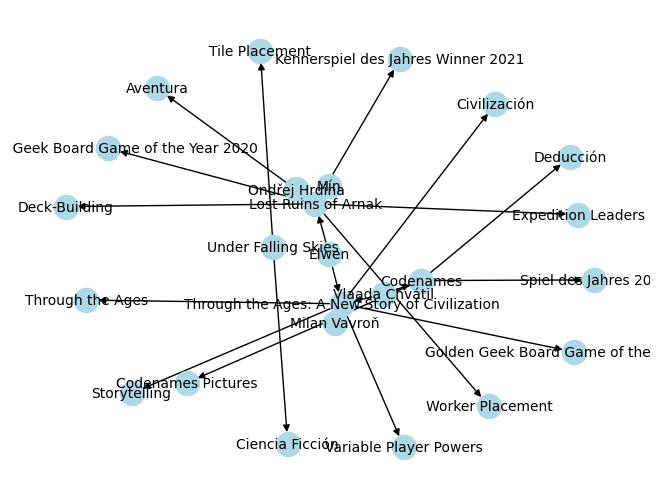

In [13]:
import networkx as nx

# Crear el grafo
G = nx.DiGraph()

# Agregar nodos
nodos = [
    ("Lost Ruins of Arnak", "game"),
    ("Through the Ages: A New Story of Civilization", "game"),
    ("Under Falling Skies", "game"),
    ("Codenames", "game"),
    ("Expedition Leaders", "expansion"),
    ("Codenames Pictures", "game"),
    ("Elwen", "creator"),
    ("Mín", "creator"),
    ("Vlaada Chvátil", "creator"),
    ("Ondřej Hrdina", "artist"),
    ("Milan Vavroň", "artist"),
    ("Deck-Building", "mechanic"),
    ("Worker Placement", "mechanic"),
    ("Storytelling", "mechanic"),
    ("Variable Player Powers", "mechanic"),
    ("Tile Placement", "mechanic"),
    ("Aventura", "category"),
    ("Civilización", "category"),
    ("Ciencia Ficción", "category"),
    ("Deducción", "category"),
    ("Kennerspiel des Jahres Winner 2021", "award"),
    ("Golden Geek Board Game of the Year 2020", "award"),
    ("Spiel des Jahres 2016", "award"),
    ("Golden Geek Board Game of the Year 2015", "award"),
]

for nodo, tipo in nodos:
    G.add_node(nodo, type=tipo)

# Agregar relaciones
relaciones = [
    ("Elwen", "Lost Ruins of Arnak", "diseñó"),
    ("Elwen", "Through the Ages: A New Story of Civilization", "diseñó"),
    ("Mín", "Lost Ruins of Arnak", "diseñó"),
    ("Vlaada Chvátil", "Through the Ages: A New Story of Civilization", "diseñó"),
    ("Vlaada Chvátil", "Codenames", "diseñó"),
    ("Ondřej Hrdina", "Lost Ruins of Arnak", "ilustró"),
    ("Milan Vavroň", "Through the Ages: A New Story of Civilization", "ilustró"),
    ("Lost Ruins of Arnak", "Deck-Building", "utiliza"),
    ("Lost Ruins of Arnak", "Worker Placement", "utiliza"),
    ("Through the Ages: A New Story of Civilization", "Storytelling", "utiliza"),
    ("Through the Ages: A New Story of Civilization", "Variable Player Powers", "utiliza"),
    ("Under Falling Skies", "Tile Placement", "utiliza"),
    ("Codenames", "Deducción", "utiliza"),
    ("Lost Ruins of Arnak", "Aventura", "pertenece_a"),
    ("Through the Ages: A New Story of Civilization", "Civilización", "pertenece_a"),
    ("Under Falling Skies", "Ciencia Ficción", "pertenece_a"),
    ("Codenames", "Deducción", "pertenece_a"),
    ("Lost Ruins of Arnak", "Kennerspiel des Jahres Winner 2021", "ganó"),
    ("Lost Ruins of Arnak", "Golden Geek Board Game of the Year 2020", "nominado_a"),
    ("Codenames", "Spiel des Jahres 2016", "ganó"),
    ("Through the Ages: A New Story of Civilization", "Golden Geek Board Game of the Year 2015", "nominado_a"),
    ("Lost Ruins of Arnak", "Expedition Leaders", "tiene_expansión"),
    ("Through the Ages: A New Story of Civilization", "Through the Ages", "reimplementación_de"),
    ("Codenames", "Codenames Pictures", "tiene_version"),
]

for origen, destino, relacion in relaciones:
    G.add_edge(origen, destino, relation=relacion)

# Visualizar el grafo
nx.draw(G, with_labels=True, node_size=300, node_color="lightblue", font_size=10)

# Clasificador basado en un modelo entrenado con ejemplos y embeddings

Definir ejemplos para que el clasificador "aprenda" y sepa dónde buscar, datos etiquetados

In [14]:
text_examples = [
    ("¿Cómo se juega Lost Ruins of Arnak?", "text"),
    ("¿Qué reglas debo seguir para el Templo de la Serpiente?", "text"),
    ("Explícame las acciones principales del juego.", "text"),
    ("¿Cuáles son los componentes del juego?", "text"),
    ("¿Qué incluye la variante en solitario?", "text"),
    ("¿Qué debo hacer para excavar en un yacimiento?", "text"),
    ("¿Cuántas rondas dura una partida?", "text"),
    ("¿Qué son los guardianes y cómo interactúan en el juego?", "text"),
    ("¿Cuáles son los recursos disponibles en el tablero?", "text"),
    ("¿Qué pasos debo seguir para iniciar una ronda?", "text"),
    ("¿Cómo funcionan los ídolos en el juego?", "text"),
    ("¿Qué acciones gratuitas puedo realizar durante mi turno?", "text"),
    ("¿Cómo se repone la fila de cartas?", "text"),
    ("¿Qué efectos tienen las cartas de miedo?", "text"),
    ("¿Qué puedo hacer si no tengo arqueólogos disponibles?", "text")
]

table_examples = [
    ("¿Cuántos jugadores pueden participar en el juego?", "table"),
    ("¿Cuál es el tiempo promedio de juego?", "table"),
    ("¿Qué edad mínima recomienda el juego?", "table"),
    ("¿Qué puntuación promedio tiene el juego?", "table"),
    ("¿Cuántos fans tiene Lost Ruins of Arnak?", "table"),
    ("¿Cuál es la desviación estándar de los ratings?", "table"),
    ("¿Qué categorías tiene el juego?", "table"),
    ("¿Qué mecánicas están disponibles en el juego?", "table"),
    ("¿Cuántos ratings ha recibido este juego?", "table"),
    ("¿Cuál es la clasificación general del juego?", "table"),
    ("¿Qué precios tiene en diferentes tiendas?", "table"),
    ("¿Qué comentarios promedio ha recibido el juego?", "table"),
    ("¿Cuántas vistas de página tiene el juego?", "table"),
    ("¿Cuál es la clasificación en juegos de estrategia?", "table"),
    ("¿Qué tan complejo es el juego según su peso?", "table")
]

graph_examples = [
    ("¿Quién diseñó Lost Ruins of Arnak?", "graph"),
    ("¿Qué otros juegos diseñó Elwen?", "graph"),
    ("¿Quién es el ilustrador del juego?", "graph"),
    ("¿Qué mecánicas utiliza el juego?", "graph"),
    ("¿Qué juegos tienen la misma categoría que Lost Ruins of Arnak?", "graph"),
    ("¿Qué premios ha ganado Lost Ruins of Arnak?", "graph"),
    ("¿Quién diseñó Through the Ages?", "graph"),
    ("¿Qué mecánicas utiliza Through the Ages?", "graph"),
    ("¿Qué expansiones tiene Lost Ruins of Arnak?", "graph"),
    ("¿Qué relación tiene Codenames con Codenames Pictures?", "graph"),
    ("¿Qué premios ganó Codenames?", "graph"),
    ("¿Qué categorías contiene Under Falling Skies?", "graph"),
    ("¿Qué juegos pertenecen a la categoría Civilización?", "graph"),
    ("¿Qué juegos utilizan Storytelling como mecánica?", "graph"),
    ("¿Qué relación tiene Lost Ruins of Arnak con Expedition Leaders?", "graph")
]

training_data = text_examples + table_examples + graph_examples

In [15]:
training_data

[('¿Cómo se juega Lost Ruins of Arnak?', 'text'),
 ('¿Qué reglas debo seguir para el Templo de la Serpiente?', 'text'),
 ('Explícame las acciones principales del juego.', 'text'),
 ('¿Cuáles son los componentes del juego?', 'text'),
 ('¿Qué incluye la variante en solitario?', 'text'),
 ('¿Qué debo hacer para excavar en un yacimiento?', 'text'),
 ('¿Cuántas rondas dura una partida?', 'text'),
 ('¿Qué son los guardianes y cómo interactúan en el juego?', 'text'),
 ('¿Cuáles son los recursos disponibles en el tablero?', 'text'),
 ('¿Qué pasos debo seguir para iniciar una ronda?', 'text'),
 ('¿Cómo funcionan los ídolos en el juego?', 'text'),
 ('¿Qué acciones gratuitas puedo realizar durante mi turno?', 'text'),
 ('¿Cómo se repone la fila de cartas?', 'text'),
 ('¿Qué efectos tienen las cartas de miedo?', 'text'),
 ('¿Qué puedo hacer si no tengo arqueólogos disponibles?', 'text'),
 ('¿Cuántos jugadores pueden participar en el juego?', 'table'),
 ('¿Cuál es el tiempo promedio de juego?', 'ta

## Generación de embeddings

Transformar el texto de entrenamiento en embeddings utilizando un modelo preentrenado de transformers. `intfloat/e5-large`, un modelo que genera embeddings optimizados para tareas de búsqueda semántica.

In [16]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Cargar modelo y tokenizer
model_name = "intfloat/e5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Función para generar embeddings
def generate_embedding(text):
    inputs = tokenizer(f"query: {text}", return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return embedding

# Generar embeddings para el dataset
examples = [example[0] for example in training_data]
labels = [example[1] for example in training_data]
embeddings = np.array([generate_embedding(text) for text in examples])

## Entrenamiento del clasificador

Entrenar un clasificador SVM (Support Vector Machine) para categorizar consultas en text, table o graph utilizando kernel lineal para separar las categorías.

El modelo ajusta los parámetros usando los embeddings como entradas y las etiquetas numéricas como salidas.

In [17]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

# Codificar las etiquetas de texto (text, table, graph) en valores numéricos (0, 1, 2).
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Entrenar el modelo SVM
classifier = SVC(kernel="linear", probability=True)
classifier.fit(embeddings, encoded_labels)


SVC(kernel='linear', probability=True)

## Clasificación de nuevas consultas

In [18]:
def classify_query(query):
    query_embedding = generate_embedding(query).reshape(1, -1)   # Generar embedding de la consulta
    prediction = classifier.predict(query_embedding)   # Predicción de la categoría
    category = label_encoder.inverse_transform(prediction)[0]   # Convertir etiqueta numérica a texto
    return category

# Ejemplo
new_query = "¿Qué premios ganó Lost Ruins of Arnak?"
predicted_category = classify_query(new_query)
print(f"La consulta pertenece a la categoría: {predicted_category}")

La consulta pertenece a la categoría: graph


## Evaluar el modelo entrenado

In [19]:
# Definir las consultas de prueba
test_queries = [
    "¿Cómo interactúan los jugadores con los templos en el juego?", # text
    "¿Cuál es la duración mínima y máxima de una partida?", # table
    "¿Quién ganó el premio Kennerspiel des Jahres 2021?", # graph
    "¿Qué juegos tienen la mecánica de colocación de trabajadores?", # graph
    "¿Cuánto pesa el juego en términos de dificultad según los jugadores?", # table
]

# Etiquetas reales (ground truth)
true_labels = ["text", "table", "graph", "graph", "table"]

# Lista para almacenar las predicciones del modelo
predicted_labels = []

# Evaluar cada consulta de prueba
for query in test_queries:
    predicted_category = classify_query(query)  # Usar tu función ya implementada
    predicted_labels.append(predicted_category)  # Guardar la predicción
    print(f"Consulta: {query}")
    print(f"Categoría Predicha: {predicted_category}")

# Comparar con las etiquetas reales
from sklearn.metrics import classification_report

# Calcular métricas
print("\nReporte de clasificación para tu modelo entrenado:")
print(classification_report(true_labels, predicted_labels))


Consulta: ¿Cómo interactúan los jugadores con los templos en el juego?
Categoría Predicha: table
Consulta: ¿Cuál es la duración mínima y máxima de una partida?
Categoría Predicha: table
Consulta: ¿Quién ganó el premio Kennerspiel des Jahres 2021?
Categoría Predicha: graph
Consulta: ¿Qué juegos tienen la mecánica de colocación de trabajadores?
Categoría Predicha: graph
Consulta: ¿Cuánto pesa el juego en términos de dificultad según los jugadores?
Categoría Predicha: table

Reporte de clasificación para tu modelo entrenado:
              precision    recall  f1-score   support

       graph       1.00      1.00      1.00         2
       table       0.67      1.00      0.80         2
        text       0.00      0.00      0.00         1

    accuracy                           0.80         5
   macro avg       0.56      0.67      0.60         5
weighted avg       0.67      0.80      0.72         5



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Clasificador basado en LLMs

Se define un template que orienta al modelo para clasificar consultas en una de tres categorías:

- **text**: Preguntas sobre reglas, explicaciones o mecánicas.
- **table**: Preguntas sobre datos tabulares como estadísticas, precios o tiempos.
- **graph**: Preguntas sobre relaciones entre juegos, creadores, premios o mecánicas.

In [20]:
PROMPT_TEMPLATE = """
Clasifica la consulta en una sola de las siguientes categorías:
- 'text': Para preguntas sobre reglas, explicaciones o mecánicas del juego.
- 'table': Para preguntas sobre datos numéricos, estadísticas o información como precio, tiempo, cantidad de jugadores, etc.
- 'graph': Para preguntas relacionadas con creadores, ilustradores, premios o relaciones entre juegos.

Consulta: {query}

Responde únicamente con una de estas palabras: text, table o graph.
"""

Modelo Utilizado: `google/flan-t5-large` está diseñado para generación de texto y clasificación mediante prompts.

In [21]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Cargar modelo y tokenizer
model_name = "google/flan-t5-large"  # Puedes probar flan-t5-base o flan-t5-large según los recursos
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

def classify_with_huggingface(query):
    """
    Clasifica una consulta en 'text', 'table' o 'graph' utilizando un modelo basado en prompts.
    """
    # Completar el prompt con la consulta
    prompt = PROMPT_TEMPLATE.format(query=query)

    # Tokenizar el prompt
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True)

    # Generar la respuesta
    outputs = model.generate(inputs.input_ids, max_length=10, num_beams=2, early_stopping=True)

    # Decodificar la respuesta generada
    classification = tokenizer.decode(outputs[0], skip_special_tokens=True).strip().lower()

    return classification

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

### Evaluar el modelo

In [22]:
test_queries = [
    "¿Cómo interactúan los jugadores con los templos en el juego?", # text
    "¿Cuál es la duración mínima y máxima de una partida?", # table
    "¿Quién ganó el premio Kennerspiel des Jahres 2021?", # graph
    "¿Qué juegos tienen la mecánica de colocación de trabajadores?", # graph
    "¿Cuánto pesa el juego en términos de dificultad según los jugadores?", # table
]

# Evaluar el modelo de HuggingFace
for query in test_queries:
    predicted_category = classify_with_huggingface(query)
    print(f"Consulta: {query}")
    print(f"Categoría Predicha: {predicted_category}\n")


Consulta: ¿Cómo interactúan los jugadores con los templos en el juego?
Categoría Predicha: text

Consulta: ¿Cuál es la duración mínima y máxima de una partida?
Categoría Predicha: table

Consulta: ¿Quién ganó el premio Kennerspiel des Jahres 2021?
Categoría Predicha: text

Consulta: ¿Qué juegos tienen la mecánica de colocación de trabajadores?
Categoría Predicha: text

Consulta: ¿Cuánto pesa el juego en términos de dificultad según los jugadores?
Categoría Predicha: table



Se evalúa el modelo con un conjunto de consultas de prueba y se compara con las etiquetas reales (true_labels).

In [23]:
from sklearn.metrics import classification_report

# Etiquetas reales (ground truth)
true_labels = ["text", "table", "graph", "graph", "table"]

# Predicciones del clasificador basado en HuggingFace
predicted_labels_hf = [classify_with_huggingface(query) for query in test_queries]

# Calcular métricas
print("Reporte de clasificación para HuggingFace:")
print(classification_report(true_labels, predicted_labels_hf))

Reporte de clasificación para HuggingFace:
              precision    recall  f1-score   support

       graph       0.00      0.00      0.00         2
       table       1.00      1.00      1.00         2
        text       0.33      1.00      0.50         1

    accuracy                           0.60         5
   macro avg       0.44      0.67      0.50         5
weighted avg       0.47      0.60      0.50         5



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Flujo de RAG

Primero, se clasifica la consulta usando el clasificador basado en embeddings o el LLM.

In [24]:
def classify_query(query):
    query_embedding = generate_embedding(query).reshape(1, -1)
    prediction = classifier.predict(query_embedding)
    category = label_encoder.inverse_transform(prediction)[0]
    return category

## Recuperar contexto desde la base de datos de texto


In [25]:
def search_text(query, collection):
    """
    Realiza una búsqueda en la base textual ChromaDB.
    """
    query_embedding = generate_embedding(query).tolist()
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=5  # Recupera los 5 documentos más relevantes
    )
    # Combinar resultados en un solo contexto
    context = " ".join(results["documents"])
    return context

## Recuperar contextodesde la base de datos tabular

In [26]:
def search_table(query, df):
    """
    Filtra datos en el DataFrame según la consulta.
    """
    if "jugadores" in query.lower():
        return df[["Título", "Jugadores"]].to_string(index=False)
    elif "precio" in query.lower():
        return df[["Título", "Precio"]].to_string(index=False)
    elif "duración" in query.lower():
        return df[["Título", "Duración"]].to_string(index=False)
    return "No se encontraron datos relevantes en la base tabular."

## Recuperar contexto desde la base de datos de grafos

In [27]:
def search_graph(query, G):
    """
    Realiza consultas en el grafo NetworkX.
    """
    if "diseñador" in query.lower():
        designers = [n for n, d in G.nodes(data=True) if d["type"] == "creator"]
        return f"Creadores disponibles: {', '.join(designers)}"
    elif "premios" in query.lower():
        awards = [n for n, d in G.nodes(data=True) if d["type"] == "award"]
        return f"Premios disponibles: {', '.join(awards)}"
    elif "mecánicas" in query.lower():
        mechanics = [n for n, d in G.nodes(data=True) if d["type"] == "mechanic"]
        return f"Mecánicas disponibles: {', '.join(mechanics)}"
    return "No se encontraron datos relevantes en el grafo."

## Generar respuesta

Una vez recuperado el contexto, se genera la respuesta usando `Flan-T5-small`.

In [28]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Cargar el modelo generativo
model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

def generate_response(query, context):
    """
    Genera una respuesta basada en la consulta y el contexto recuperado.
    """
    prompt = f"Consulta: {query}\nContexto: {context}\nResponde de forma clara:"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True)

    if inputs.input_ids is None or inputs.input_ids.size(1) == 0:
        raise ValueError("Los input_ids no se generaron correctamente. Revisa el prompt.")

    outputs = model.generate(
        inputs.input_ids,
        max_length=150,
        early_stopping=True
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

## Ejecución Completa del Flujo RAG

In [29]:
def execute_rag(query, collection, df, G):
    category = classify_query(query)
    print(f"Consulta clasificada como: {category}")

    if category == "text":
        context = search_text(query, collection)
    elif category == "table":
        context = search_table(query, df)
    elif category == "graph":
        context = search_graph(query, G)
    else:
        return "No entiendo tu consulta."

    # Verificar si el contexto es válido
    if not context or context.strip() == "":
        return "No se encontró información relevante para tu consulta."

    response = generate_response(query, context)
    return response


## Ejemplo de uso

In [30]:
def test_prompt():
    prompt = "¿Quién diseñó Lost Ruins of Arnak?"
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(
        inputs.input_ids,
        max_length=50,
        num_beams=3,  # Usar 3 caminos simultáneos para beam search
    early_stopping=True  # Ahora tiene efecto
)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Respuesta de prueba:", test_prompt())

Respuesta de prueba: antonio del rafo


Consultas específicas para probar luego:

* Text (ChromaDB):

"¿Cómo se juega Lost Ruins of Arnak?"

"¿Qué reglas debo seguir para el Templo de la Serpiente?"

* Table (DataFrame):

"¿Cuál es la duración mínima y máxima del juego?"

"¿Qué edad mínima recomienda el juego?"

* Graph (NetworkX):

"¿Qué juegos tienen la misma categoría que Lost Ruins of Arnak?"

"¿Qué premios ha ganado Lost Ruins of Arnak?"

# Agente

In [ ]:
!pip install llama-index==0.10.10

In [8]:
from llama_index.core.tools import FunctionTool

# Funciones para interactuar con las bases

def search_text_db(query):
    """
    Busca información en la base de datos textual (ChromaDB).
    """
    query_embedding = generate_embedding(query).tolist()
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=5
    )
    return " ".join(results["documents"])

In [9]:
def search_tabular_db(query):
    """
    Filtra datos relevantes en el DataFrame tabular según la consulta.
    """
    if "jugadores" in query.lower():
        return df["Jugadores"].to_string(index=False)
    elif "precio" in query.lower():
        return df["Tiendas y Precios"].to_string(index=False)
    elif "duración" in query.lower():
        return df["Tiempo de Juego (min)"].to_string(index=False)
    return "No se encontraron datos relevantes en la base tabular."

In [10]:
def search_graph_db(query):
    """
    Realiza consultas en la base de datos de grafos.
    """
    if "diseñador" in query.lower():
        designers = [origen for origen, destino, data in G.edges(data=True) if data["relation"] == "diseñó"]
        return f"Los diseñadores son: {', '.join(designers)}"
    elif "premios" in query.lower():
        awards = [n for n, d in G.nodes(data=True) if d["type"] == "award"]
        return f"Premios disponibles: {', '.join(awards)}"
    elif "mecánicas" in query.lower():
        mechanics = [n for n, d in G.nodes(data=True) if d["type"] == "mechanic"]
        return f"Mecánicas disponibles: {', '.join(mechanics)}"
    return "No se encontraron datos relevantes en el grafo."

In [12]:
# Registrar herramientas
text_search_tool = FunctionTool.from_defaults(
    fn=search_text_db,
    description="Busca información en la base de datos textual."
)

tabular_search_tool = FunctionTool.from_defaults(
    fn=search_tabular_db,
    description="Busca información en la base tabular."
)

graph_search_tool = FunctionTool.from_defaults(
    fn=search_graph_db,
    description="Busca información en la base de grafos."
)

In [ ]:
from typing import Any, Sequence
from llama_index.llms.types import LLM, LLMMetadata
from llama_index.core.llms.types import ChatMessage, ChatResponse

class CustomLLM(LLM):
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    @property
    def metadata(self) -> LLMMetadata:
        return LLMMetadata(
            context_window=512,  # Ajusta según las especificaciones de tu modelo
            num_output=100,      # Ajusta según las especificaciones de tu modelo
            model_name="custom_huggingface_model"
        )

    def chat(self, messages: Sequence[ChatMessage], **kwargs: Any) -> ChatResponse:
        prompt = messages[-1].content  # Suponiendo que el último mensaje es del usuario
        inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True)
        outputs = self.model.generate(inputs.input_ids, max_length=100, num_beams=3, early_stopping=True)
        response_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return ChatResponse(message=ChatMessage(role="assistant", content=response_text))

In [13]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Modelo HuggingFace
model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

def huggingface_chat(prompt: str) -> str:
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True)
    outputs = model.generate(inputs.input_ids, max_length=100, num_beams=3, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
from llama_index.core.agent.react.base import ReActAgent

# Crear el agente ReAct
tools = [text_search_tool, tabular_search_tool, graph_search_tool]
agent = ReActAgent.from_tools(tools=tools, llm=huggingface_chat)

In [ ]:
# Ejecutar una consulta
response = agent.chat("What is the summary of Lost Ruins of Arnak?")
print("Respuesta del agente:", response)